extract trajectory output  
1. depth_dic.json  
2. start.json  
3. speed_dic.json  

In [1]:
# depth 추출
import numpy as np
import os

def load_npy_files(directory):
    npy_files = [f for f in os.listdir(directory) if f.endswith('metric_depth.npy')]
    data_list = []
    for file in npy_files:
        data = np.load(os.path.join(directory, file))
        data_list.append(data)
    return data_list

directory_path = 'intersection/object_depths'
depth_map_list = load_npy_files(directory_path)

# depth map 길이 (=프레임 개수)
print(len(depth_map_list))

500


In [2]:
# 동영상 fps, shape 추출
import cv2
cap = cv2.VideoCapture('intersection/intersection1.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

height, width = depth_map_list[0].shape

In [3]:
print(fps)

15.0


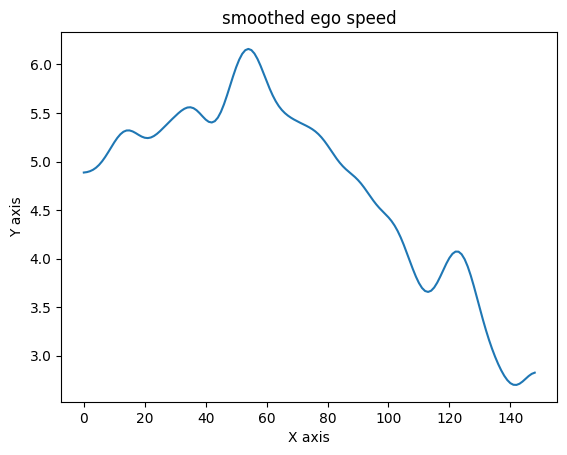

In [4]:
# ego speed 추출, smoothing
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

ego_speed_data = np.load('intersection/ego_speed.npy', allow_pickle=True)
ego_speed_data=gaussian_filter1d(ego_speed_data, sigma=5)

# 그래프 그리기
plt.plot(ego_speed_data)

plt.title("smoothed ego speed")
plt.xlabel("X axis")
plt.ylabel("Y axis")

plt.show()

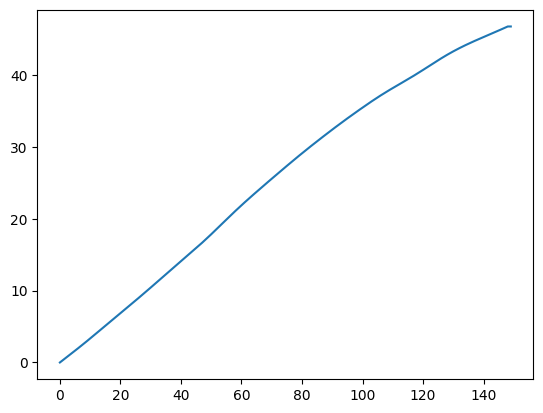

In [5]:
# ego 궤적 (z축)
ego_position = np.zeros((len(ego_speed_data))+1)

ego_position[1]=ego_position[0]+1

for i in range(1, len(ego_speed_data)):
    ego_position[i]=ego_position[i-1]+ego_speed_data[i]/fps

ego_position[-1]=ego_position[-2]
plt.plot(ego_position)

In [6]:
# tracked data 추출
tracked_data = np.load('crop_tracked_data.npy', allow_pickle=True)  ##이부분 바꿈
tracking_len = len(tracked_data)
print(tracking_len)

print(height, width)


90
1080 1920


In [7]:
def make_points(vehicle): ##vehicle 별로 point 추출
    result = [[] for _ in range(len(tracked_data))]
    for i, data in enumerate(tracked_data):
        if vehicle in data:
            points = data[vehicle]
            for garo in range(int(points[0]), int(points[2])):
                for sero in range(int(points[1]), int(points[3])):
                    point=garo, sero
                    result[i].append(point)
        else:
            center = None, None
            result[i].append(center)
    return result

In [8]:
def get_depth(frame, x, y) :
    if x==None or y==None :
        return None
    else :
        return depth_map_list[frame][y][x]

In [9]:
def custom_median(data, trim_percent=10):
    # None 값을 제외하고 데이터를 오름차순으로 정렬
    sorted_data = sorted([x for x in data if x is not None])
    n = len(sorted_data)
    
    # 절단할 데이터 개수 계산
    trim_count = int(n * trim_percent / 100)
    
    # 상하위 trim_count 만큼 데이터 절단
    trimmed_data = sorted_data[trim_count : n - trim_count]
    
    # 절단된 데이터의 평균 계산
    if trimmed_data:
        return sum(trimmed_data) / len(trimmed_data)
    else:
        return None  # 절단 후 데이터가 없는 경우


In [10]:
# 동영상 내부 파라미터 입력
fx, fy, cx, cy = 1316.81, 738.72, 960, 540

def get_3dpoint(v, u, d):
    if v==None or u==None or d==None :
        return (None, None, None)
    
    Z = d
    X = (v - cx) * Z / fx
    Y = (u - cy) * Z / fy
    return [X, Y, Z]

In [11]:
# 특정 포인트의 x, y, z 구하기
def cal_x_y_z(points):
    x_list=[]
    y_list=[]
    z_list=[]
    for frame, point in enumerate(points):
        x_temp=[]
        y_temp=[]
        z_temp=[]
        for pp in point:
            u, v=pp
            d=get_depth(frame, u, v)
            x, y, z = get_3dpoint(u, v, d)
            x_temp.append(x)
            y_temp.append(y)
            z_temp.append(z)
        x_list.append(custom_median(x_temp))
        y_list.append(custom_median(y_temp))
        z_list.append(custom_median(z_temp))
    return x_list, y_list, z_list

In [12]:
# 속도 구하기 (z값만 고려)
def cal_velocity(x_list, z_list):
    vel=[] #속도 리스트
    previous_value_none=True #전 값이 None이였는지
    for i in range(len(x_list)):
        if x_list[i]==None or z_list[i]==None :
            vel.append(None)
            previous_value_none=True
        else :
            if previous_value_none :
                vel.append(None)
                previous_value_none=False
            else :
                #vel.append((((x_list[i]-x_list[i-1])*(x_list[i]-x_list[i-1])+(z_list[i]-z_list[i-1])*(z_list[i]-z_list[i-1]))**0.5)*fps)
                #vel.append((((z_list[i]-z_list[i-1])*(z_list[i]-z_list[i-1]))**0.5)*fps)
                vel.append((((z_list[i]-z_list[i-1])))*fps)
    return vel

In [13]:
import numpy as np
from scipy.ndimage import gaussian_filter1d


# NaN을 무시하고 가우시안 필터를 적용하는 함수 정의
def nan_gaussian_filter1d_separate(arr, sigma):
    nan_mask = np.isnan(arr)  # NaN 위치 마스크
    
    # NaN을 기준으로 구간을 나누고, 각 구간에 가우시안 필터 적용
    segments = []
    current_segment = []
    
    for i, val in enumerate(arr):
        if np.isnan(val):
            # 현재 구간이 비어있지 않으면, 해당 구간에 가우시안 필터 적용 후 저장
            if current_segment:
                segment_data = np.array(current_segment)
                filtered_segment = gaussian_filter1d(segment_data, sigma=sigma)
                segments.append(filtered_segment)
                current_segment = []  # 구간 초기화
            segments.append(np.nan)  # NaN은 그대로 저장
        else:
            current_segment.append(val)
    
    # 마지막 구간 처리
    if current_segment:
        segment_data = np.array(current_segment)
        filtered_segment = gaussian_filter1d(segment_data, sigma=sigma)
        segments.append(filtered_segment)
    
    # 필터링된 구간을 다시 합쳐서 원래 배열 형태로 복원
    result = []
    for segment in segments:
        if isinstance(segment, np.ndarray):
            result.extend(segment)
        else:
            result.append(segment)
    
    return np.array(result)



vehicle4


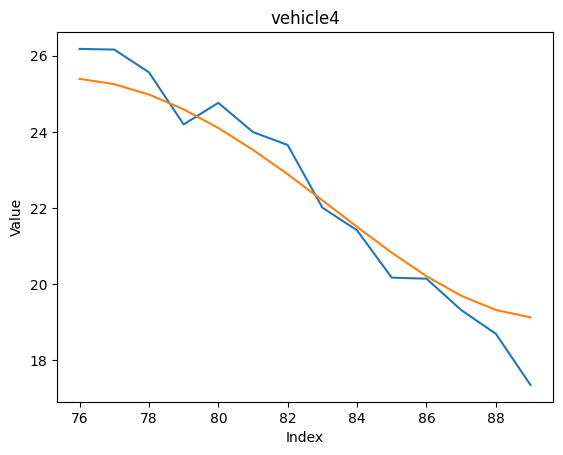

vehicle6


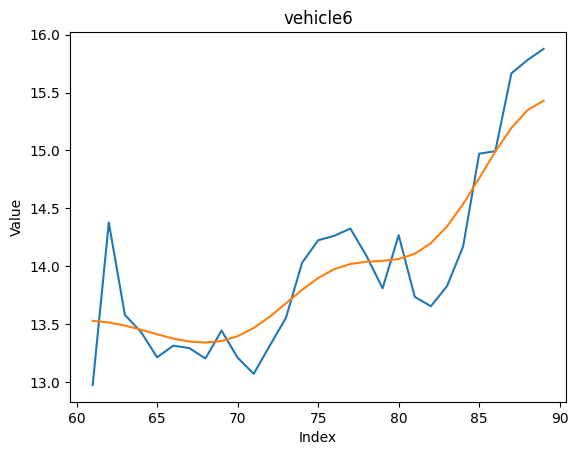

vehicle0


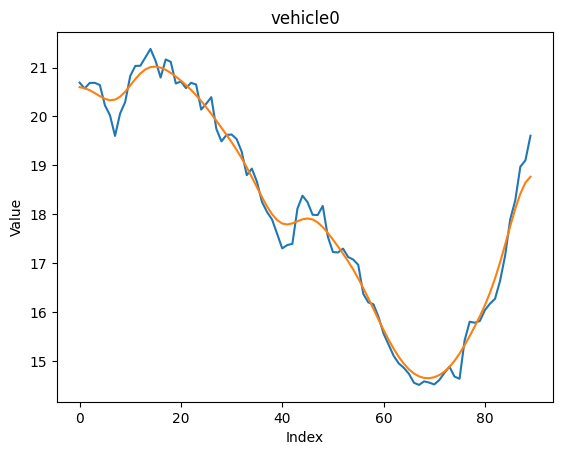

In [14]:
####### origin depth, smoothed vehicle 별 출력
import json
import matplotlib.pyplot as plt

all_vehicles = set(key for data in tracked_data for key in data.keys())
velocity_dic = {}
depth_dic = {}
for vehicle in all_vehicles:
    print(vehicle)
    points = make_points(vehicle)
    x_list, y_list, z_list=cal_x_y_z(points)
    plt.plot(z_list)

    z_list=np.array(z_list, dtype=np.float32)
    z_list = np.where(z_list == None, np.nan, z_list)

    z_list = nan_gaussian_filter1d_separate(z_list, sigma=3)
    plt.plot(z_list)

    
    vel=cal_velocity(x_list, z_list)
    velocity_dic[vehicle]=vel    
    # 그래프에 제목 및 레이블 추가
    plt.title(vehicle)
    plt.xlabel('Index')
    plt.ylabel('Value')

    # 그래프 표시
    plt.show()


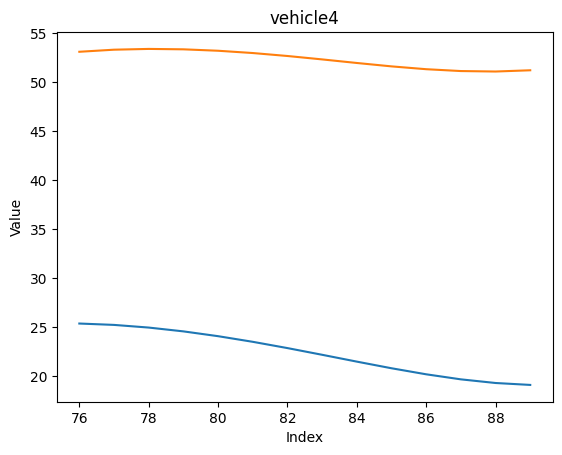

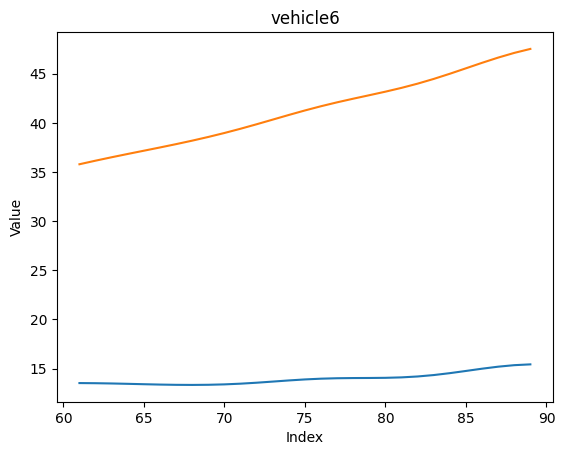

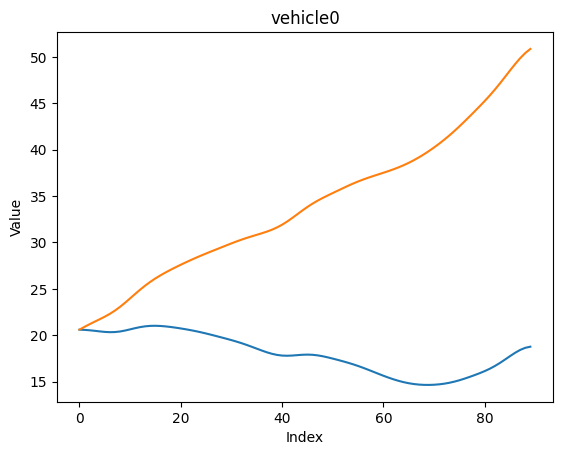

In [15]:

####### vehicle 상대 궤적, 절대 궤적(ego 차량 궤적 더한 값) plot
import json
import matplotlib.pyplot as plt

all_vehicles = set(key for data in tracked_data for key in data.keys())
velocity_dic = {}
depth_dic = {}
for vehicle in all_vehicles:
    points = make_points(vehicle)
    x_list, y_list, z_list=cal_x_y_z(points)
 

    z_list=np.array(z_list, dtype=np.float32)
    z_list = np.where(z_list == None, np.nan, z_list)
    z_list = nan_gaussian_filter1d_separate(z_list, sigma=3)
    plt.plot(z_list)

    z_list+=ego_position[:len(z_list)]
    plt.plot(z_list, label=vehicle)
    # vel=cal_velocity(x_list, z_list)
    # velocity_dic[vehicle]=vel    
    # 그래프에 제목 및 레이블 추가
    plt.title(vehicle)
    plt.xlabel('Index')
    plt.ylabel('Value')

    # 그래프 표시
    plt.show()


In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression

def interpolate(array):
    y=np.array(array)
    # 유효한 (NaN이 아닌) 인덱스와 값 추출
    not_nan_indices = np.where(~np.isnan(y))[0]
    not_nan_values = y[not_nan_indices]
    
    # NaN 인덱스 추출
    nan_indices = np.where(np.isnan(y))[0]
    if len(nan_indices)==0: ## 복원 필요 없음
        return array
    
    # 학습을 위한 x 값과 y 값 생성 (index 값들을 x로 사용)
    x_train = not_nan_indices.reshape(-1, 1)  # NaN이 아닌 인덱스
    y_train = not_nan_values  # NaN이 아닌 y 값
    
    # 선형 회귀 모델 학습
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    # NaN 위치 예측
    x_predict = nan_indices.reshape(-1, 1)
    y_predict = model.predict(x_predict)
    
    # 예측된 값으로 NaN 채우기
    y[nan_indices] = y_predict

    return y


vehicle4 -0.006086810251300255
vehicle6 -0.14298315597384165
turn vehicle6, [5.749328312837962, 5.802158530034744, 5.898113456398414, 6.021099729033992, 6.153621588834806, 6.281196080377187, 6.394661135176586, 6.490161212261429, 6.56763391027613, 6.628917701713217, 6.676286995135598, 6.711704499456496, 6.736687476303903, 6.752515208036997, 6.760532168402959, 6.762360377589346, 6.759945396572962, 6.755458017206933, 6.751089608892732, 6.748809394518305, 6.750149309174412, 6.756065303741419, 6.766898589655308, 6.7824324989001425, 6.802017068104021, 6.824719869693579, 6.849461201531475, 6.87510435120869, 6.9004930956976445, 6.924451897660271, 6.945781755334415, 6.963289959264073, 6.97588262414321, 6.982726869558989, 6.983461360936928, 6.978408494788851, 6.9687276007416585, 6.956451655727088, 6.944370732980841, 6.935758821348214, 6.933977624727734, 6.942021803548556, 6.962086723323894, 6.995238776420573, 7.041251438839203, 7.098642732560208, 7.164918025639496, 7.236988993714952, 7.311703662

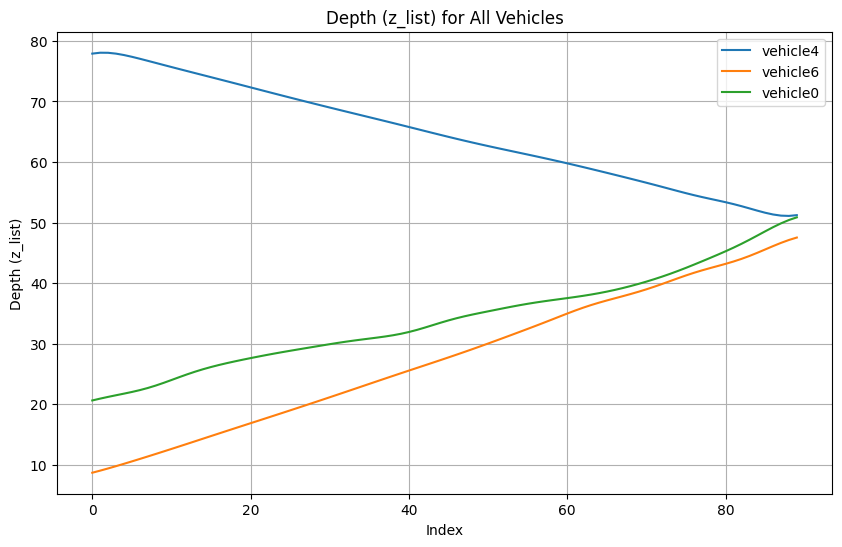

In [17]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

all_vehicles = set(key for data in tracked_data for key in data.keys())
all_depth_dic = {}

depth_dic = {}
x_dic={}

turn_dic = {}
straight = []

# 모든 vehicle의 그래프를 하나의 figure에 그리기 위해 plt.figure() 호출
plt.figure(figsize=(10, 6))

for vehicle in all_vehicles:
    points = make_points(vehicle)
    x_list, y_list, z_list = cal_x_y_z(points)

    z_list = np.array(z_list, dtype=np.float32)
    z_list = np.where(z_list == None, np.nan, z_list)

    x_list = np.array(x_list, dtype=np.float32)
    x_list = np.where(x_list == None, np.nan, x_list)

    z_list = interpolate(z_list)
    x_list = interpolate(x_list)

    z_list = nan_gaussian_filter1d_separate(z_list, sigma=3)
    x_list = nan_gaussian_filter1d_separate(x_list, sigma=3)    
    
    differences = np.diff(x_list)
    average_slope = sum(differences) / len(differences)
    print(vehicle, average_slope)

    # ego_position 반영
    z_list+=ego_position[:len(z_list)]
    
    if average_slope < -0.05:        
        distances = np.sqrt(np.diff(x_list)**2 + np.diff(z_list)**2)
        speed = []
        for distance in distances:
            speed.append(distance*fps)
        turn_dic[vehicle] = nan_gaussian_filter1d_separate(speed, sigma=3).tolist()
        print(f'turn {vehicle}, {turn_dic[vehicle]}')
        x_dic[vehicle]=x_list
        all_depth_dic[vehicle]=z_list
        plt.plot(z_list, label=vehicle)

    
    # dictionary 채우기
    if not average_slope < -0.05:
        z_list=interpolate(z_list)
        straight.append(vehicle)
        depth_dic[vehicle]=z_list
        all_depth_dic[vehicle]=z_list
        x_dic[vehicle]=x_list
        
        # 각 vehicle의 z_filled 값을 한 그래프에 그리기, label에 vehicle 이름 추가
        plt.plot(z_list, label=vehicle)

# 그래프에 제목 및 레이블 추가
plt.title('Depth (z_list) for All Vehicles')
plt.xlabel('Index')
plt.ylabel('Depth (z_list)')
plt.legend(loc='best')  # 각 vehicle의 이름을 표시하는 범례 추가
plt.grid(True)

# 그래프 표시
plt.show()

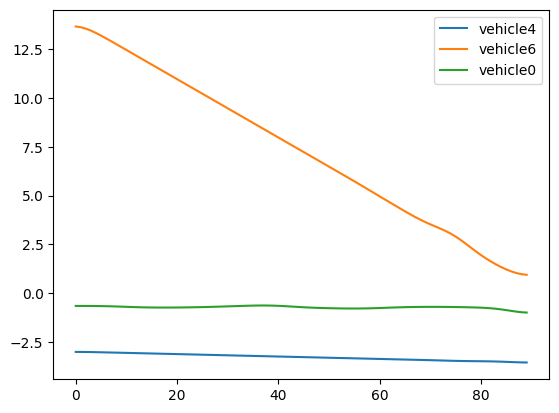

In [18]:
for vehicle in x_dic.keys():
    plt.plot(x_dic[vehicle], label=vehicle)
    plt.legend(loc='best')  # 각 vehicle의 이름을 표시하는 범례 추가

In [19]:
def overall_trend(arr, threshold=0.7):
    diffs = np.diff(arr)
    positive_count = np.sum((diffs > 0) & ~np.isnan(diffs))
    negative_count = np.sum((diffs < 0) & ~np.isnan(diffs))

    positive_ratio = positive_count / (positive_count+negative_count)
    negative_ratio = negative_count / (positive_count+negative_count)

    if positive_ratio >= threshold:
        return 1 #대체로 증가
    elif negative_ratio >= threshold:
        return 0 #대체로 감소

orient_dic={}

for vehicle in x_dic.keys():
    temp=overall_trend(all_depth_dic[vehicle])
    if temp==1:
        orient_dic[vehicle]=1
    elif temp==0:
        orient_dic[vehicle]=-1


for vehicle in turn_dic.keys():
    orient_dic[vehicle]=2

orient_dic

{'vehicle4': -1, 'vehicle6': 2, 'vehicle0': 1}

In [20]:
import json

# 예시 dictionary

# json으로 저장
with open('lane.json', 'w') as f:
    json.dump(orient_dic, f)

In [21]:
x_dic = {key: value.tolist() for key, value in x_dic.items()}
with open('x_dic.json', 'w') as f:
    json.dump(x_dic, f)

In [22]:
with open('rotation_speed.json', 'w') as f:
    json.dump(turn_dic, f)

In [23]:
all_depth_dic = {key: value.tolist() for key, value in all_depth_dic.items()}
with open('all_depth_dic.json', 'w') as f:
    json.dump((all_depth_dic), f)

In [25]:
import numpy as np

def depth_to_speed(depth, fps=15):
    time_interval = 1 / fps
    depth_diff = np.diff(depth)
    speed = depth_diff / time_interval
    
    return speed

speed_dic = {}

for key, depth_values in all_depth_dic.items():
    speed_dic[key] = depth_to_speed(depth_values, fps=15)
    # plt.plot(speed, label=key)  # 각 객체의 속도를 같은 그래프에 표시
    # plt.title(f"{key} Speed over Frames by Object")
    # plt.xlabel("Frame")
    # plt.ylabel("Speed")
    # plt.show()

In [26]:
speed_dic

{'vehicle4': array([ 2.21717834, -0.17417908, -2.09323883, -3.47019196, -4.34864044,
        -4.84039307, -5.07282257, -5.15304565, -5.15590668, -5.12580872,
        -5.08701324, -5.05210876, -5.02670288, -5.01342773, -5.01296997,
        -5.02269745, -5.0396347 , -5.05908966, -5.07648468, -5.08838654,
        -5.09181976, -5.08563995, -5.07064819, -5.04821777, -5.02063751,
        -4.99019623, -4.95872498, -4.92702484, -4.89578247, -4.86545563,
        -4.83650208, -4.81052399, -4.78981018, -4.77676392, -4.7744751 ,
        -4.78363037, -4.8046875 , -4.83467102, -4.86911774, -4.90127563,
        -4.92404938, -4.93114471, -4.9174118 , -4.88079071, -4.8217392 ,
        -4.74363327, -4.65173721, -4.55286026, -4.45392609, -4.36220169,
        -4.283638  , -4.22367096, -4.18619156, -4.17331696, -4.18533325,
        -4.22080994, -4.2760849 , -4.34612274, -4.42445755, -4.50519562,
        -4.5826149 , -4.65265274, -4.71290588, -4.76308823, -4.80382919,
        -4.83833313, -4.87117767, -4.90

In [27]:
# speed JSON 파일로 저장
speed_dic_converted = {key: value.tolist() for key, value in speed_dic.items()}

with open("speed_dic.json", "w") as json_file:
    json.dump(speed_dic_converted, json_file)

In [29]:
start = {}
for vehicle, point in all_depth_dic.items():
    start[vehicle] = point[0]

In [30]:
with open("start.json", "w") as json_file:
    json.dump(start, json_file)